Title: Integrating & Exploring 4: Automated Bulk Downloads of Landsat-8 Data Products in Python
Date: 2018-01-09 16:00
Modified: 2018-01-09 16:00
Category: Remote-Sensing
Tags: remote-sensing, landsat, gis
Slug: get-landsat-8
Authors: Bruno Ruas de Pinho
Email: brunorpinho10@gmail.com
Summary: Earth Explorer provides a very good interface to download Landsat-8 data. However, we usually want to automate the process and run everything without spending time with GUIs. In this tutorial, I will show how to automate the bulk download of low Cloud Covered Landsat-8 images, in Python, from Amazon or Google servers.

Multispectral and hyperspectral satellites are amazing (I'm a huge fan). I tend to think them as a super human vision. Soviet and American space stations started to be launched with multispectral devices in it's equipments in the yearly 70's. From them, space scientists have improved it to a solid earth observation system for all kinds of purposes. Today, with these instruments, scientists can accurately categorize trillion of surface pixels, find not only visible, but invisible information, control illegal actions and plan our future as a civilization.

The [Landsat Mission](https://landsat.usgs.gov/) is a [joint initiative between the U.S. Geological Survey (USGS) and NASA](https://landsat.usgs.gov/landsat-project-description), officially described as:

> The world's longest continuously acquired collection of space-based moderate-resolution land remote sensing data.

The Landsat is currently on the eighth of it's series. Landsat-8 data is currently freely available on the USGS's [Earth Explorer](https://earthexplorer.usgs.gov/) website. All we need to do is sign up and find a scene  that match our area of study. However, in this tutorial, I will show you how to automate the bulk download of low Cloud Covered Landsat-8 images from the comfort your Python!

This is the **PART 4** of a series of posts called **Integrating & Exploring**. 

### Area of Study

Iron River in Michigan, USA

## Tutorial

Import `pandas` and `geopandas` for easy manipulation and filtering of tables and vector files.`folium` for interactive map views. `os` and `shutil` for file/folder manipulation.

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import os, shutil
from glob import glob

Let's read the vector containing the bounds of the Area of Study. This was processed on previous posts.

In [2]:
bounds = gpd.read_file('./data/processed/area_of_study_bounds.gpkg')

### Picking the Best Scenes

The notation used to catalog Landsat-8 images is called [Worldwide Reference System 2 (WRS-2)](https://landsat.usgs.gov/what-worldwide-reference-system-wrs). The Landsat follows the same `paths` imaging the earth every 16 days. Each `path` is split into multiple `rows`. So, each scene have a `path` and a `row`. 16 days later, another scene will have the same `path` and `row` than the previous scene. This is the essence of the WRS-2 system.

USGS provides [Shape files](https://landsat.usgs.gov/pathrow-shapefiles) of these `paths` and `rows` that let us quickly visualize, interact and select the important images.

Let us get the shape files and unpack it. I will first download the file to WRS_PATH and extract it to LANDSAT_PATH.

In [3]:
WRS_PATH = './data/external/Landsat8/wrs2_descending.zip'
LANDSAT_PATH = os.path.dirname(WRS_PATH)

In [3]:
!wget -P {LANDSAT_PATH} https://landsat.usgs.gov/sites/default/files/documents/wrs2_descending.zip

shutil.unpack_archive(WRS_PATH, os.path.join(LANDSAT_PATH, 'wrs2'))

--2018-01-10 09:24:42--  https://landsat.usgs.gov/sites/default/files/documents/wrs2_descending.zip
Resolving landsat.usgs.gov (landsat.usgs.gov)... 152.61.136.10, 2001:49c8:4000:122c::10
Connecting to landsat.usgs.gov (landsat.usgs.gov)|152.61.136.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4985564 (4.8M) [application/zip]
Saving to: ‘./data/external/Landsat8/wrs2_descending.zip.4’

./data/external/Lan 100%[=====================>]   4.75M  1.44MB/s   in 3.3s   

2018-01-10 09:24:47 (1.44 MB/s) - ‘./data/external/Landsat8/wrs2_descending.zip.4’ saved [4985564/4985564]



Import it to a `GeoDataFrame` using `geopandas`. Check the first 5 entries.

In [344]:
wrs = gpd.GeoDataFrame.from_file('./data/external/Landsat8/wrs2/wrs2_descending.shp')

wrs.head()

AREA  DAYCLASS MODE  PATH  PERIMETER     PR  PR_  PR_ID  RINGS_NOK  \
0  15.74326         1    D    13   26.98611  13001    1      1          0   
1  14.55366         1    D    13   25.84254  13002    2      2          0   
2  13.37247         1    D    13   24.20303  13003    3      3          0   
3  12.26691         1    D    13   22.40265  13004    4      4          0   
4  11.26511         1    D    13   20.64284  13005    5      5          0   

   RINGS_OK  ROW  SEQUENCE  WRSPR  \
0         1    1      2233  13001   
1         1    2      2234  13002   
2         1    3      2235  13003   
3         1    4      2236  13004   
4         1    5      2237  13005   

                                            geometry  
0  POLYGON ((-10.80341356392465 80.9888, -8.97406...  
1  POLYGON ((-29.24250366707619 80.18681161921363...  
2  POLYGON ((-24.04205646041896 79.12261247629547...  
3  POLYGON ((-36.66813132081753 77.46094098591608...  
4  POLYGON ((-44.11209517917457 76.93655561966702...

Now, we can check which Polygons of the WRS-2 system intersects with the `bounds` vector.

In [14]:
wrs_intersection = wrs[wrs.intersects(bounds.geometry[0])]

Also, let's put the calculated paths and rows in a variable.

In [19]:
paths, rows = wrs_intersection['PATH'].values, wrs_intersection['ROW'].values

Create a map to visualize the `paths and rows` that intersects. 
~~~
Click on the Polygon to get the path and row value.
~~~

In [349]:
# Get the center of the map
xy = np.asarray(bounds.centroid[0].xy).squeeze()
center = list(xy[::-1])

# Select a zoom
zoom = 6

# Create the most basic OSM folium map
m = folium.Map(location=center, zoom_start=zoom, control_scale=True)

# Add the bounds GeoDataFrame in red
m.add_child(folium.GeoJson(bounds.__geo_interface__, name='Area of Study', 
                           style_function=lambda x: {'color': 'red', 'alpha': 0}))

# Iterate through each Polygon of paths and rows intersecting the area
for i, row in wrs_intersection.iterrows():
    # Create a string for the name containing the path and row of this Polygon
    name = 'path: %03d, row: %03d' % (row.PATH, row.ROW)
    # Create the folium geometry of this Polygon 
    g = folium.GeoJson(row.geometry.__geo_interface__, name=name)
    # Add a folium Popup object with the name string
    g.add_child(folium.Popup(name))
    # Add the object to the map
    g.add_to(m)

folium.LayerControl().add_to(m)
m.save('./images/10/wrs.html')
m

Let's use boolean to remove the paths and rows that intersects just a tiny bit with the area. (`paths` higher than 26 and lower than 23). This could be done by a threshold of intersection area.

In [350]:
b = (paths > 23) & (paths < 26)
paths = paths[b]
rows = rows[b]

We end up with four pairs of `path` and `row` values that would give images covering the area of study.

In [354]:
for i, (path, row) in enumerate(zip(paths, rows)):
    print('Image', i+1, ' - path:', path, 'row:', row)

Image 1  - path: 25 row: 27
Image 2  - path: 25 row: 28
Image 3  - path: 24 row: 28
Image 4  - path: 24 row: 27


### Checking Available Images on Amazon S3 & Google Storage

[Google](https://cloud.google.com/storage/docs/public-datasets/landsat) and [Amazon](https://aws.amazon.com/public-datasets/landsat/) provides public access to Landsat images. 

We can get a DataFrame of available scenes to download in each server using the `urls` above. The Amazon S3 table has ~20 MB of rows describing the existing data while the Google Storage table has ~500 MB.

In [131]:
s3_scenes = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz', compression='gzip')
# google_scenes = pd.read_csv('https://storage.googleapis.com/gcp-public-data-landsat/index.csv.gz', compression='gzip')

First 3 entries:

In [356]:
s3_scenes.head(3)

productId               entityId  \
0  LC08_L1TP_149039_20170411_20170415_01_T1  LC81490392017101LGN00   
1  LC08_L1TP_012001_20170411_20170415_01_T1  LC80120012017101LGN00   
2  LC08_L1TP_012002_20170411_20170415_01_T1  LC80120022017101LGN00   

              acquisitionDate  cloudCover processingLevel  path  row  \
0  2017-04-11 05:36:29.349932        0.00            L1TP   149   39   
1  2017-04-11 15:14:40.001201        0.15            L1TP    12    1   
2  2017-04-11 15:15:03.871058        0.38            L1TP    12    2   

    min_lat   min_lon   max_lat   max_lon  \
0  29.22165  72.41205  31.34742  74.84666   
1  79.51504 -22.06995  81.90314  -7.44339   
2  78.74882 -29.24387  81.14549 -15.04330   

                                        download_url  
0  https://s3-us-west-2.amazonaws.com/landsat-pds...  
1  https://s3-us-west-2.amazonaws.com/landsat-pds...  
2  https://s3-us-west-2.amazonaws.com/landsat-pds...

Now, let's use the previous defined paths and rows intersecting the area and see if there are any available Landsat-8 images in the Amazon S3 storage. 

Also, we can select only the images that have a percentage of cloud covering the image less than 5%.

We also want to exclude the product that end with `_T2` and `_RT`, since these are files that must go through calibration and pre-processing. [More info!](https://landsat.usgs.gov/landsat-collections)

In [364]:
# Empty list to add the images
bulk_list = []

# Iterate through paths and rows
for path, row in zip(paths, rows):
    
    print('Path:',path, 'Row:', row)
    
    # Filter the Landsat Amazon S3 table for images matching path, row, cloudcover and processing state.
    scenes = s3_scenes[(s3_scenes.path == path) & (s3_scenes.row == row) & 
                       (s3_scenes.cloudCover <= 5) & 
                       (~s3_scenes.productId.str.contains('_T2')) &
                       (~s3_scenes.productId.str.contains('_RT'))]
    print(' Found {} images\n'.format(len(scenes)))
    
    # If any scenes exists, select the one that have the minimum cloudCover.
    if len(scenes):
        scene = scenes.sort_values('cloudCover').iloc[0]
    
    # Add the selected scene to the bulk download list.
    bulk_list.append(scene)

Path: 25 Row: 27
 Found 2 images

Path: 25 Row: 28
 Found 6 images

Path: 24 Row: 28
 Found 3 images

Path: 24 Row: 27
 Found 6 images



Check the four images that were selected.

In [365]:
bulk_frame = pd.concat(bulk_list, 1).T
bulk_frame

productId               entityId  \
679     LC08_L1TP_025027_20170406_20170414_01_T1  LC80250272017096LGN00   
226329  LC08_L1TP_025028_20170913_20170928_01_T1  LC80250282017256LGN00   
255166  LC08_L1TP_024028_20171008_20171023_01_T1  LC80240282017281LGN00   
127668  LC08_L1TP_024027_20170720_20170728_01_T1  LC80240272017201LGN00   

                   acquisitionDate cloudCover processingLevel path row  \
679     2017-04-06 16:45:24.051124       1.51            L1TP   25  27   
226329  2017-09-13 16:46:22.160327       0.06            L1TP   25  28   
255166  2017-10-08 16:40:21.299100       0.23            L1TP   24  28   
127668  2017-07-20 16:39:33.524611       3.11            L1TP   24  27   

        min_lat  min_lon  max_lat  max_lon  \
679     46.3107 -91.0755  48.4892 -87.8023   
226329  44.8846 -91.5385  47.0651 -88.3262   
255166  44.9159 -89.9783  47.0759  -86.858   
127668  46.3429 -89.4354  48.5005 -86.2616   

                                             download_url  
679     https://s3-us-west-2.amazonaws.com/landsat-pds...  
226329  https://s3-us-west-2.amazonaws.com/landsat-pds...  
255166  https://s3-us-west-2.amazonaws.com/landsat-pds...  
127668  https://s3-us-west-2.amazonaws.com/landsat-pds...

Last step is to download all files for each of the 4 products, including metadata (.MTL), QA and overviews. 
Then, add each product files to it's own folder.

In [329]:
# Import requests and beautiful soup
import requests
from bs4 import BeautifulSoup

# For each row
for i, row in bulk_frame.iterrows():
    
    # Print some the product ID
    print('\n', 'EntityId:', row.productId, '\n')
    print(' Checking content: ', '\n')
    
    # Request the html text of the download_url from the amazon server. 
    # download_url example: https://landsat-pds.s3.amazonaws.com/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/index.html
    response = requests.get(row.download_url)
    
    # If the response status code is fine (200)
    if response.status_code == 200:
        
        # Import the html to beautiful soup
        html = BeautifulSoup(response.content, 'html.parser')
        
        # Create the dir where we will put this image files.
        entity_dir = os.path.join(LANDSAT_PATH, row.productId)
        os.makedirs(entity_dir, exist_ok=True)
        
        # Second loop: for each band of this image that we find using the html <li> tag
        for li in html.find_all('li'):
            
            # Get the href tag
            file = li.find_next('a').get('href')
            
            print('  Downloading: {}'.format(file))
            
            # Download the files
            # code from: https://stackoverflow.com/a/18043472/5361345
            
            response = requests.get(row.download_url.replace('index.html', file), stream=True)
            
            with open(os.path.join(entity_dir, file), 'wb') as output:
                shutil.copyfileobj(response.raw, output)
            del response

EntityId: LC08_L1TP_025027_20170406_20170414_01_T1 

 Checking content:  

  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B9.TIF.ovr
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B11.TIF
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B11.TIF.ovr
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B10.TIF
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B5.TIF
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_BQA.TIF
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B3.TIF.ovr
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_BQA_wrk.IMD
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B9.TIF
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B4.TIF
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B1_wrk.IMD
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B6.TIF
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B3.TIF
  Downloading: LC08_L1TP_025027_20170406_20170414_01_T1_B4.TIF.ovr
  Downloading:

  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B2_wrk.IMD
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B4.TIF
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B7.TIF
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B6.TIF.ovr
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B9_wrk.IMD
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B7_wrk.IMD
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B4_wrk.IMD
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B10_wrk.IMD
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B11.TIF
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B4.TIF.ovr
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B1.TIF
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B3.TIF
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B3_wrk.IMD
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_B8.TIF
  Downloading: LC08_L1TP_024027_20170720_20170728_01_T1_BQA_wrk.IMD
  Downloading: L

Let's check the images.

In [31]:
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
%matplotlib inline

Read the rasters using rasterio and extract the bounds.

In [14]:
xmin, xmax, ymin, ymax = [], [], [], []

for image_path in glob(os.path.join(LANDSAT_PATH, '*/*B10.TIF')):
    with rasterio.open(image_path) as src_raster:
        xmin.append(src_raster.bounds.left)
        xmax.append(src_raster.bounds.right)        
        ymin.append(src_raster.bounds.bottom)        
        ymax.append(src_raster.bounds.top)        

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.6/site-packages/rasterio/warp.py:250: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  if src_transform and guard_transform(src_transform).is_identity:
/opt/conda/lib/python3.6/site-packages/rasterio/warp.py:256: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  src_transform = guard_transform(src_transform).to_gdal()


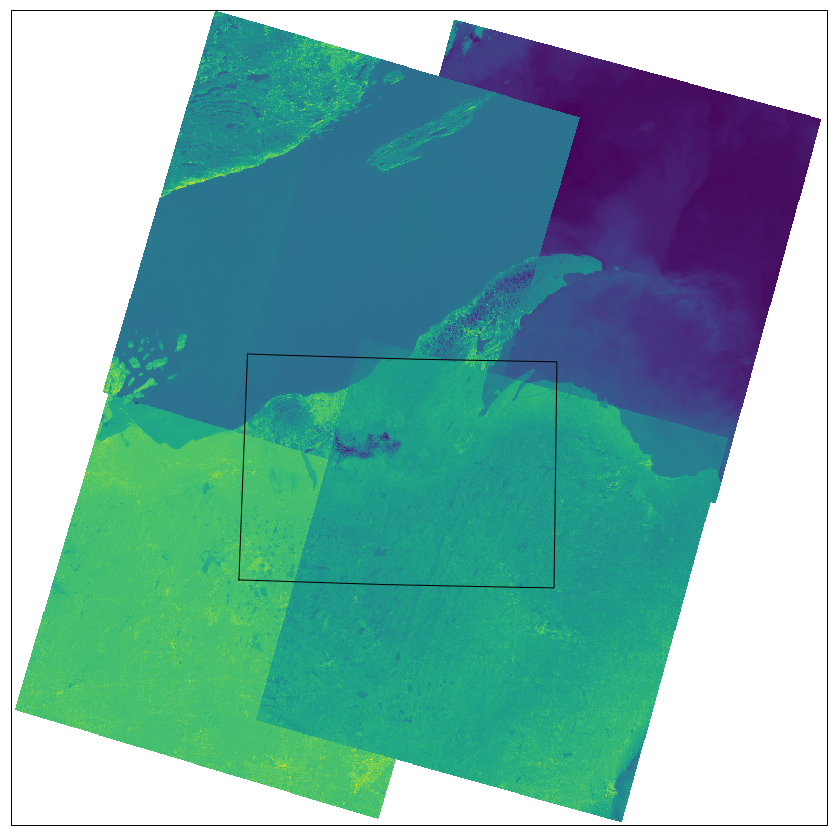

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15), subplot_kw={'projection': ccrs.UTM(16)})

ax.set_extent([min(xmin), max(xmax), min(ymin), max(ymax)], ccrs.UTM(16))

bounds.plot(ax=ax, transform=ccrs.PlateCarree())

for image_path in glob(os.path.join(LANDSAT_PATH, '*/*B10.TIF')):
    
    with rasterio.open(image_path) as src_raster:
        
        extent = [src_raster.bounds[i] for i in [0, 2, 1, 3]]  
        
        dst_transform = from_origin(src_raster.bounds.left, src_raster.bounds.top, 250, 250)
        
        width = np.ceil((src_raster.bounds.right - src_raster.bounds.left) / 250.).astype('uint')
        height = np.ceil((src_raster.bounds.top - src_raster.bounds.bottom) / 250.).astype('uint')
        
        dst = np.zeros((height, width))
        
        reproject(src_raster.read(1), dst, 
                  src_transform=src_raster.transform, 
                  dst_transform=dst_transform,
                  resampling=Resampling.nearest)
        
        ax.matshow(np.ma.masked_equal(dst, 0), extent=extent, transform=ccrs.UTM(16))
        
        
fig.savefig('./images/10/landsat.png')

That's it, I download all the images that cover the area of study. Next post, I will go step-by-step on how to derivate the Top of Atmosphere (TOA) radiance, reflectance and brightness temperature. Merge and clip the files.